In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from models.flow import build_model
from models.utils import standard_normal_logprob

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [2]:
def _generate_data(n=100, std=0.1):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 4*np.pi - 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.1):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return (
        torch.Tensor(np.concatenate([y1, y2])).reshape(-1, 1).to(DEVICE),
        torch.Tensor(np.concatenate([x1, x2])).to(DEVICE),   
    )

In [3]:
y, x = generate_data(n=300, std=0.1)
y, x = y.cpu().numpy(), x.cpu().numpy()

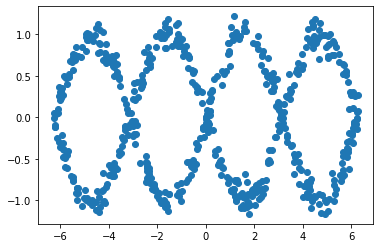

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
flow = build_model(
    input_dim=1,
    hidden_dims=(40,40,40,),
    context_dim=1,
    conditional=True,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatscale"
).to(DEVICE)

optimizer = optim.Adam(flow.parameters())

In [ ]:
num_iter = 1000

with tqdm(range(num_iter)) as pbar:
    for i in pbar:
        iks, context = generate_data(n=300, std=0.1)
        optimizer.zero_grad()

        zero = torch.zeros(iks.shape[0], 1).to(DEVICE)
        z, delta_logp = flow(x=iks, context=context, logpx=zero)  # run model forward

        logpz = standard_normal_logprob(z).view(z.shape[0], -1).sum(1, keepdim=True)  # logp(z)
        logpx = logpz - delta_logp

        loss = -logpx.mean()
        pbar.set_description(f"Loss {loss:.2f}")

        loss.backward()
        optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torchdiffeq/_impl/misc.py:326: UserWarning: torch.nextafter is only available in PyTorch 1.7 or newer.Falling back to numpy.nextafter. Upgrade PyTorch to remove this warning.
  warnings.warn("torch.nextafter is only available in PyTorch 1.7 or newer."
Loss 0.15:  38%|███▊      | 381/1000 [04:43<11:11,  1.08s/it] 

In [ ]:
n_samples = 50

x_new = torch.linspace(-2*np.pi, 2*np.pi, 101).repeat(n_samples).to(DEVICE)
z = torch.randn(len(x_new), 1).to(DEVICE)

y = flow(x=z, context=x_new, reverse=True)
y = y.detach().cpu().numpy()

plt.scatter(x_new.detach().cpu().numpy(), y)
plt.show()

In [ ]:
n_samples = 100

x_new = torch.Tensor([-2.0]).repeat(n_samples).to(DEVICE)
z = torch.randn(len(x_new), 1).to(DEVICE)

y = flow(x=z, context=x_new, reverse=True)
y = y.detach().cpu().numpy()

plt.scatter(x_new.detach().cpu().numpy(), y)
plt.show()